In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import sklearn

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
import missingno as msno

#ignore warnings
import warnings
warnings.filterwarnings('ignore') # 워닝 메세지를 생략해 줍니다. 차후 버전관리를 위해 필요한 정보라고 생각하시면 주석처리 하시면 됩니다.

%matplotlib inline

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/2019-1st-ml-month-with-kakr/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/2019-1st-ml-month-with-kakr/test.csv')
df_submit = pd.read_csv('/content/drive/MyDrive/2019-1st-ml-month-with-kakr/sample_submission.csv')

### 결측치 확인

In [ ]:
# 먼저 결측치의 비율이 어느정도 되는지 확인 한다

df_train.isnull().sum() / df_train.shape[0]

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [ ]:

df_test.isnull().sum() / df_test.shape[0]

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64

2.6 Family - SibSp(형제 자매) + Parch(부모, 자녀)
SibSp와 Parch를 합치면 함께 탑승한 가족의 수가 될 것입니다.
이 두 피쳐를 더해서 새로운 피쳐 FamilySize를 만들어 보도록 하겠습니다.
(사실 새로운 피쳐를 만들어 내는 건 특성 공학쪽에서 다뤄야 하지만 일단 미리 보겠습니다.)

In [ ]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다

Cabin은 NaN값이 80% 이상이다. 사용하기 어려워 보인다
[결측치처리방법](https://zhining.tistory.com/27)
Ticket은 NaN값은 없으나 value가 너무 많다

3. 특성 공학 (Feature Engineering)¶
본격적인 feature engineering 

"Garbage In, Garbage out"

특성 공학을 통해 다양 피쳐를 만드시고, 정제할 때
자기가 생각한 가정이 항상 타당한지 생각하시고 진행해 주시길 바랍니다!
아무리 좋은 모델도, 안좋은 데이터가 들어오면 안좋은 결과로 이어진다

가장 먼저, dataset 에 존재하는 null data를 채운다
아무 숫자로 채울 수는 없고, null data 를 포함하는 feature 의 statistics 를 참고하거나,
다른 아이디어를 짜내어 채울 수 있다.

*null data 를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에, 신경써줘야할 부분.*

특히, Feature engineering 은 실제 모델의 학습에 쓰려고 하는 것이므로,
### train 뿐만 아니라 test 도 똑같이 적용해주어야 한다. 잊지말자
https://nachwon.github.io/regular-expressions/ 헷갈리는 정규표현식


In [ ]:
df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

In [ ]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [ ]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

<Axes: xlabel='Initial'>

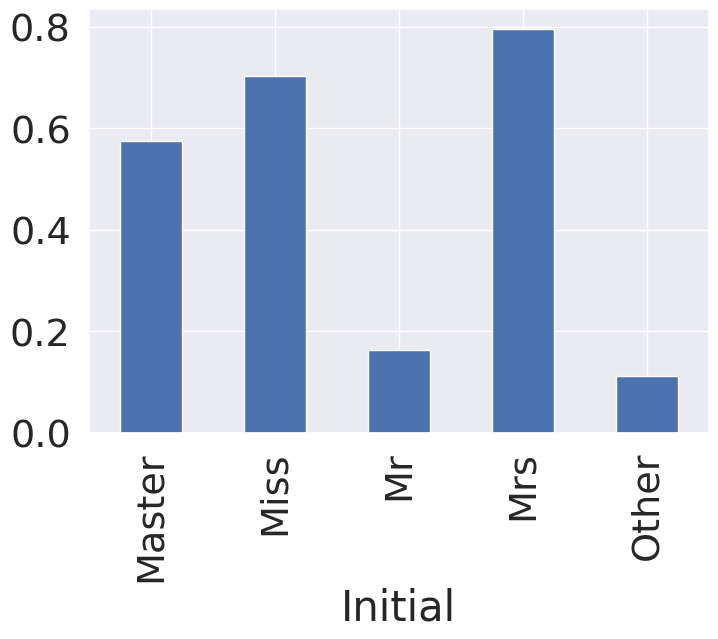

In [ ]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

In [ ]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

In [ ]:
print(df_train.isnull().sum()[df_train.isnull().sum() > 0])
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean() # testset 에 있는 nan value 를
print(df_test.isnull().sum()[df_test.isnull().sum() > 0])

Cabin       687
Embarked      2
dtype: int64
Cabin    327
dtype: int64


In [ ]:
# train의 embark 채우기

df_train['Embarked'].fillna('S', inplace=True)

In [ ]:
df_train.isnull().sum()[df_train.isnull().sum() > 0]

Cabin    687
dtype: int64

3.2. Change Age(continuous to categorical)¶
Age 는 현재 continuous feature 입니다. 이대로 써도 모델을 세울 수 있지만,
Age 를 몇개의 group 으로 나누어 category 화 시켜준다

continuous 를 categorical 로 바꾸면 자칫 information loss 가 생길 수도 있습니다만,
본 튜토리얼에서는 다양한 방법을 소개하는 것이 목적이므로 진행하도록 하겠습니다.

방법은 여러가지가 있습니다.
dataframe 의 indexing 방법인 loc 를 사용하여 직접해줄 수 있고,
아니면 apply 를 사용해 함수를 넣어줄 수 있습니다.

loc 예제는 위의 age mean 값을 채워 줬을 때 사용해 봤으므로,
여기에선 apply를 사용해 보도록 하겠습니다.

In [ ]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7

df_train['Age_cat'] = df_train['Age'].apply(category_age)
df_test['Age_cat'] = df_test['Age'].apply(category_age)

In [ ]:
df_train.groupby(['Age_cat'])['PassengerId'].count()

Age_cat
0     66
1    102
2    256
3    304
4     89
5     48
6     19
7      7
Name: PassengerId, dtype: int64

In [ ]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

In [ ]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [ ]:
df_train['Embarked'].isnull().any() , df_train['Embarked'].dtypes

(False, dtype('int64'))

In [ ]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

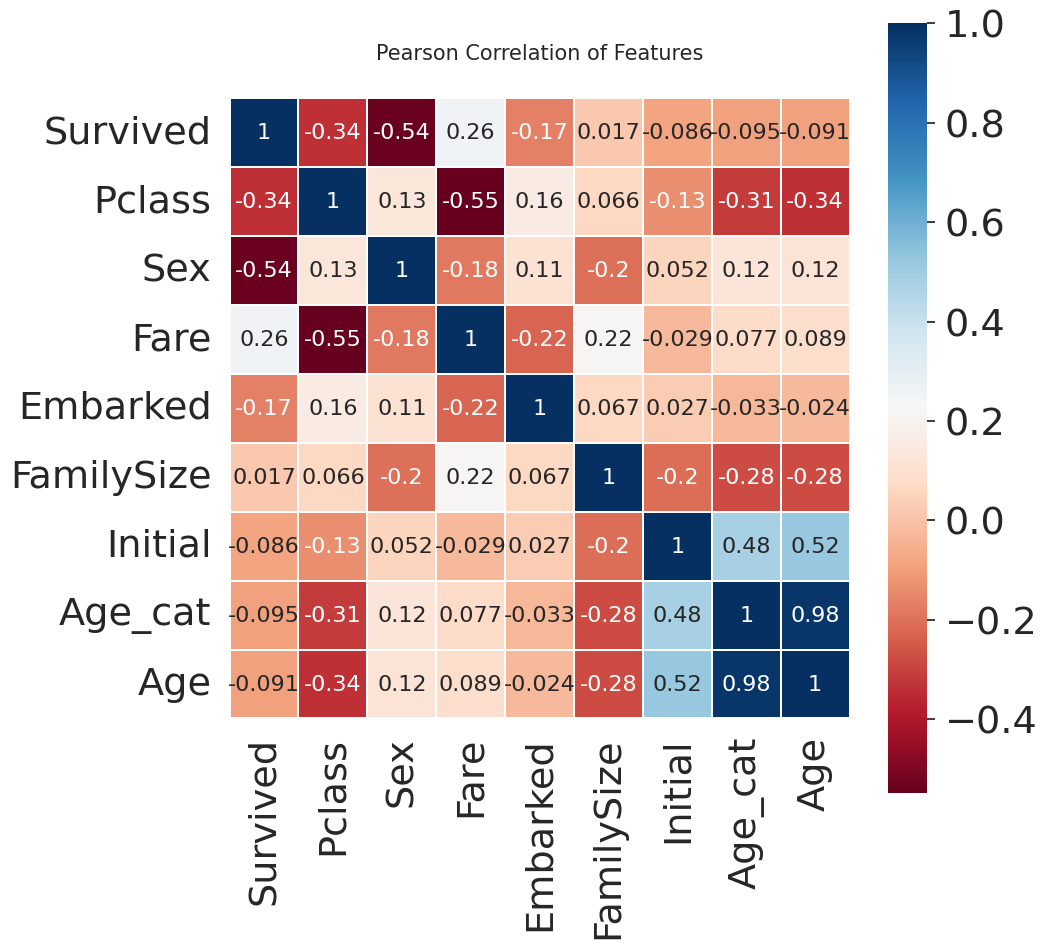

In [ ]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat', 'Age']]

colormap = plt.cm.RdBu
plt.figure(figsize=(10, 10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

서로 강한 상관관계인 feature들이 없다 => 불필요한 feature가 없다

In [ ]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [ ]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2,2,2,False,False,True,False,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0,2,3,False,False,False,True,False
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,1,2,False,True,False,False,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2,2,3,False,False,False,True,False
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,2,1,3,False,False,True,False,False


In [ ]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

In [ ]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,2,2,False,False,True,False,False,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,2,3,False,False,False,True,False,True,False,False
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,1,2,False,True,False,False,False,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,2,3,False,False,False,True,False,False,False,True
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,1,3,False,False,True,False,False,False,False,True


In [ ]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

필요 없는 칼럼은 다 지운다

In [ ]:
df_train.dtypes

Survived        int64
Pclass          int64
Sex             int64
Age           float64
Fare          float64
FamilySize      int64
Age_cat         int64
Initial_0        bool
Initial_1        bool
Initial_2        bool
Initial_3        bool
Initial_4        bool
Embarked_0       bool
Embarked_1       bool
Embarked_2       bool
dtype: object

In [ ]:
df_test.head()

,Pclass,Sex,Age,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,34.5,7.8292,1,3,False,False,True,False,False,False,True,False
1,3,0,47.0,7.0000,2,4,False,False,False,True,False,False,False,True
2,2,1,62.0,9.6875,1,6,False,False,True,False,False,False,True,False
3,3,1,27.0,8.6625,1,2,False,False,True,False,False,False,False,True
4,3,0,22.0,12.2875,3,2,False,False,False,True,False,False,False,True


### 전처리 끝 ! 이제 모델 개발을 하자!!

In [ ]:
#importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier # 유명한 randomforestclassfier 입니다.
from sklearn import metrics # 모델의 평가를 위해서 씁니다
from sklearn.model_selection import train_test_split # traning set을 쉽게 나눠주는 함수입니다.

In [ ]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

In [ ]:
X_train.shape, X_test.shape

((891, 14), (418, 14))

In [ ]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.2, random_state=2018)

In [ ]:
y_tr.shape, y_vld.shape

((712,), (179,))

In [ ]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [ ]:
metrics.accuracy_score(prediction, y_vld)

0.8100558659217877

학습된 모델은 feature importance 를 가지게 되는데,
우리는 이것을 확인하여 지금 만든 모델이 어떤 feature 에 영향을 많이 받았는 지 확인할 수 있습니다.

쉽게 말해, y = 4*x1 + 2*x2 + 1*x3 을 생각하면,
우리는 x1이 결과값(10)에 큰 영향을 준다고 생각 할 수 있습니다.

feature importance 는 4, 2, 1 을 이야기하며, x1이 가장 큰 값(4)를 가지므로,
이 모델에 x1 피쳐가 가장 큰 영향을 미친다고 말할 수 있습니다.

학습된 모델은 기본적으로 feature importances 를 가지고 있어서 쉽게 그 수치를 얻을 수 있습니다.
pandas series 를 이용하면 쉽게 sorting 을 하여 그래프를 그릴 수 있습니다.

In [ ]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

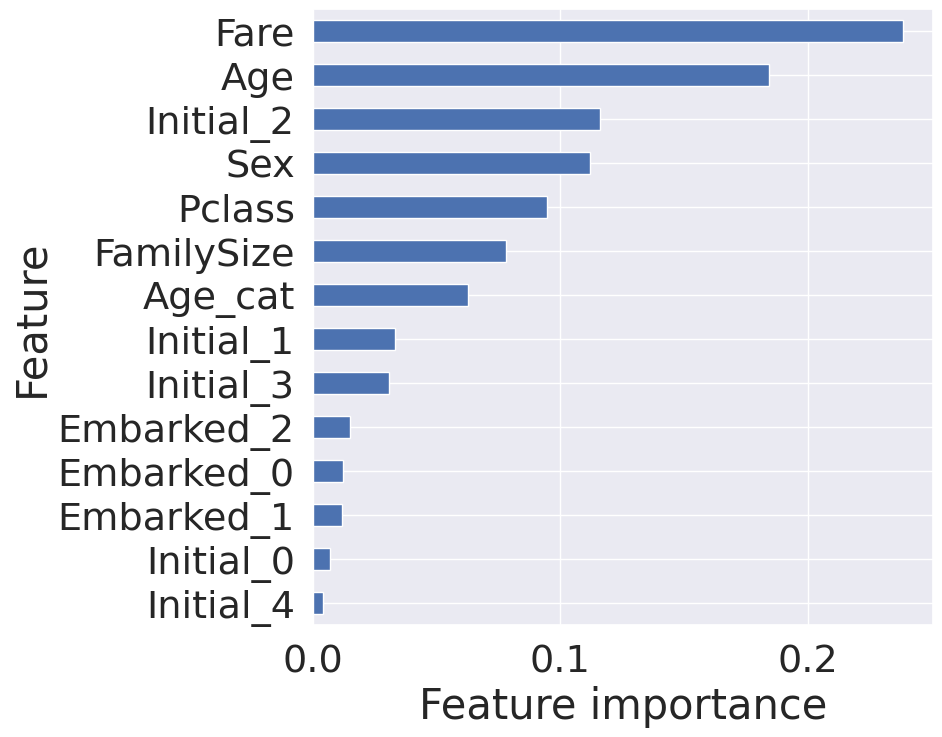

In [ ]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

[놀라운 인사이트]('https://www.kaggle.com/competitions/2019-1st-ml-month-with-kakr/discussion/80547')